<left><img src="https://blog.desafiolatam.com/wp-content/uploads/2019/02/logo.png"></left>

# Proyecto DataScience 

María Teresa Moncada Moraga

Felipe Riveros

José Pozo

Nicolas Vasquez

24-08-2022

# Analisis exploratorio del dataset

### Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import random
import math
import funciones as fn
import pickle
warnings.filterwarnings(action= 'ignore')
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10,6)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier 
from sklearn.metrics import f1_score, accuracy_score, classification_report, roc_auc_score, roc_curve
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

modelos e hiperparametros a utilizar

| **Modelos** 	| **Hiperparametro** 	|
|:---:	|:---:	|
| Regresion Logistica 	| C:[0,0001 0.001, 0.01, 0.1]<br><br>penalty:['l1', 'l2', 'none']<br><br> 'class_weight': ['balanced']<br><br>'solver':['newton-cg']|
| Naive Bayes 	| alpha = [0.1, 0.5, 1]<br><br>fit_prior=[True,False] 	|
|    Random Forest    	|                     n_estimators = [50, 200, 500]<br><br> max_features = [0.5, 0.7, 'log2']<br><br> bootstrap = [False, True]<br><br>max_depth = [3, 6, 8] <br><br> class_weight = ['balanced'] <br><br> criterion = ['entropy']                 	|
|         SVM         	|         C = [0.1, 1, 5]<br><br>gamma = [0.0001, 0.01, 0.1]        	|
|  Gradient Boosting  	| n_estimators = [100, 500, 1000] <br><br>learning_rate = [0.01, 0.1, 0.5, 1]<br><br>subsample = (0.1, 1.0, 5) <br><br> max_features = ['auto', 'sqrt', 'log2']|
| Adaptative Boosting 	|                         n_estimators = [100, 1000, 10] <br><br>learning_rate = [0.01, 100, 10]                        	|

### lectura de dataset

In [2]:
df = pd.read_csv('data/Desafio4_modelamiento.csv')

vista del dataset

In [3]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


#### visualizacion vector objetivo 

In [4]:
df['TARGET'] = np.where(df['TARGET'] == 1, 'no_paga', 'paga')

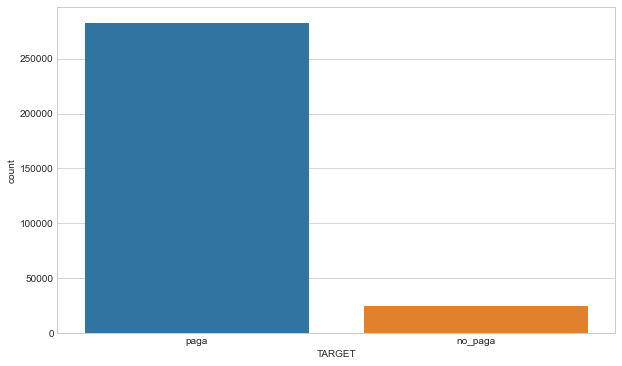

In [5]:
sns.countplot(x = df['TARGET'], order = df['TARGET'].value_counts().index);


se observa un desbalance en el vector objetivo, donde hay una mayor cantidad de datos 0, que representa a las personas con un buen perfil de pago

#### visualizacion para la eleccion de una submuestra

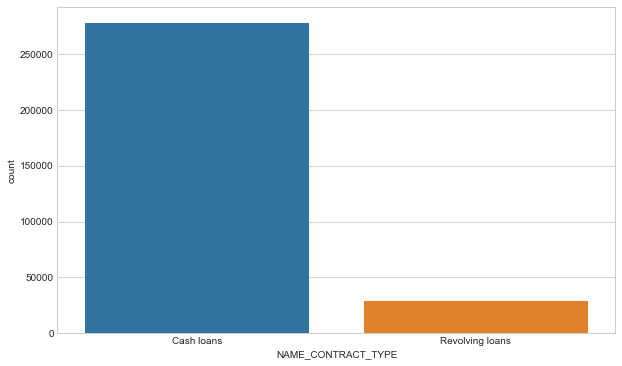

In [6]:
sns.countplot(x = df['NAME_CONTRACT_TYPE'], order = df['NAME_CONTRACT_TYPE'].value_counts().index);

existe un mayor numero de datos para 'cash loans', por lo que se elige la submuestra donde NAME_CONTRACT_TYPE == 'cash loans'

#### Visualizacion de dataset para testeo de modelos

In [7]:
df_test = pd.read_csv('data/Desafio4_Validacion.csv')

In [8]:
print(df.shape)
print(df_test.shape)

(307511, 122)
(48744, 121)


se puede ver que el dataset para testeo cuenta con un atributo menos que el dataset para entrenamiento

In [9]:
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
difference_1 = set(df.columns).difference(set(df_test.columns))
difference_2 = set(df_test.columns).difference(set(df.columns))

list_difference = list(difference_1.union(difference_2))
print(list_difference)

['TARGET']


El atributo que falta es el atributo escogido como vector objetivo

### Segmentacion de la data 'NAME_CONTRACT_TYPE' == 'Cash loans'

In [11]:
df = df[df['NAME_CONTRACT_TYPE'] == 'Cash loans']
print('cantidad de datos:')
print(df['TARGET'].value_counts())

print(df['TARGET'].value_counts('%'))

cantidad de datos:
paga       255011
no_paga     23221
Name: TARGET, dtype: int64
paga       0.916541
no_paga    0.083459
Name: TARGET, dtype: float64


distribucion de datos por atributos, visualizacion de datos nulos Nan

In [12]:
#Inspección de datos perdidos
for column_name in df.columns:
    fn.list_na(df, column_name, print_list = False)
print("##################################################")
print("% Total de datos perdidos:",(df.shape[0]-df.dropna().shape[0])/df.shape[0]*100)

#################### SK_ID_CURR : int64 ######################
La cantidad de registros perdidos es: 0
El porcentaje de registros perdidos es: 0.0
#################### TARGET : object ######################
La cantidad de registros perdidos es: 0
El porcentaje de registros perdidos es: 0.0
#################### NAME_CONTRACT_TYPE : object ######################
La cantidad de registros perdidos es: 0
El porcentaje de registros perdidos es: 0.0
#################### CODE_GENDER : object ######################
La cantidad de registros perdidos es: 0
El porcentaje de registros perdidos es: 0.0
#################### FLAG_OWN_CAR : object ######################
La cantidad de registros perdidos es: 0
El porcentaje de registros perdidos es: 0.0
#################### FLAG_OWN_REALTY : object ######################
La cantidad de registros perdidos es: 0
El porcentaje de registros perdidos es: 0.0
#################### CNT_CHILDREN : int64 ######################
La cantidad de registros perdidos es

El porcentaje de registros perdidos es: 50.79286350958911
#################### FLOORSMAX_MODE : float64 ######################
La cantidad de registros perdidos es: 139669
El porcentaje de registros perdidos es: 50.19875499583082
#################### FLOORSMIN_MODE : float64 ######################
La cantidad de registros perdidos es: 189714
El porcentaje de registros perdidos es: 68.18554300008626
#################### LANDAREA_MODE : float64 ######################
La cantidad de registros perdidos es: 166332
El porcentaje de registros perdidos es: 59.781764858104026
#################### LIVINGAPARTMENTS_MODE : float64 ######################
La cantidad de registros perdidos es: 191063
El porcentaje de registros perdidos es: 68.67039017798096
#################### LIVINGAREA_MODE : float64 ######################
La cantidad de registros perdidos es: 140817
El porcentaje de registros perdidos es: 50.6113603036315
#################### NONLIVINGAPARTMENTS_MODE : float64 ###################

La cantidad de registros perdidos es: 37239
El porcentaje de registros perdidos es: 13.384154231001466
#################### AMT_REQ_CREDIT_BUREAU_WEEK : float64 ######################
La cantidad de registros perdidos es: 37239
El porcentaje de registros perdidos es: 13.384154231001466
#################### AMT_REQ_CREDIT_BUREAU_MON : float64 ######################
La cantidad de registros perdidos es: 37239
El porcentaje de registros perdidos es: 13.384154231001466
#################### AMT_REQ_CREDIT_BUREAU_QRT : float64 ######################
La cantidad de registros perdidos es: 37239
El porcentaje de registros perdidos es: 13.384154231001466
#################### AMT_REQ_CREDIT_BUREAU_YEAR : float64 ######################
La cantidad de registros perdidos es: 37239
El porcentaje de registros perdidos es: 13.384154231001466
##################################################
% Total de datos perdidos: 97.2469018660686


In [13]:
dtype_objects = []
for i in df.columns:
    if df[i].dtypes == 'object':
        dtype_objects.append(i)

for x in dtype_objects:
    print(df[x].value_counts())

paga       255011
no_paga     23221
Name: TARGET, dtype: int64
Cash loans    278232
Name: NAME_CONTRACT_TYPE, dtype: int64
F    182800
M     95432
Name: CODE_GENDER, dtype: int64
N    183775
Y     94457
Name: FLAG_OWN_CAR, dtype: int64
Y    190207
N     88025
Name: FLAG_OWN_REALTY, dtype: int64
Unaccompanied      224541
Family              36687
Spouse, partner     10431
Children             2965
Other_B              1592
Other_A               766
Group of people       243
Name: NAME_TYPE_SUITE, dtype: int64
Working                 142719
Commercial associate     63652
Pensioner                51993
State servant            19836
Student                     15
Unemployed                  15
Maternity leave              2
Name: NAME_INCOME_TYPE, dtype: int64
Secondary / secondary special    200125
Higher education                  65321
Incomplete higher                  9032
Lower secondary                    3608
Academic degree                     146
Name: NAME_EDUCATION_TYPE, dtype

dispercion de los datos aprox

In [14]:
pd.set_option('display.max_columns', 130)
df.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,278232.000000,278232.000000,2.782320e+05,2.782320e+05,278220.000000,2.782320e+05,278232.000000,278232.000000,278232.000000,278232.000000,278232.000000,94452.000000,278232.000000,278232.000000,278232.000000,278232.000000,278232.000000,278232.000000,278232.000000,278232.000000,278232.000000,278232.000000,278232.000000,278232.000000,278232.000000,278232.000000,278232.000000,278232.000000,120217.000000,2.776330e+05,223574.000000,135824.000000,114278.000000,141294.000000,92241.000000,82996.000000,128741.000000,136910.000000,138563.000000,88518.000000,111900.000000,87169.000000,137415.000000,84178.000000,123530.000000,135824.000000,114278.000000,141294.000000,92241.000000,82996.000000,128741.000000,136910.000000,138563.000000,88518.000000,111900.000000,87169.000000,137415.000000,84178.000000,123530.000000,135824.000000,114278.000000,141294.000000,92241.00000,82996.000000,128741.000000,136910.000000,138563.000000,88518.000000,111900.000000,87169.000000,137415.000000,84178.000000,123530.000000,142718.000000,278231.000000,278231.000000,278231.000000,278231.000000,278231.000000,278232.000000,278232.000000,278232.000000,278232.000000,278232.000000,278232.0,278232.000000,278232.000000,278232.0,278232.000000,278232.000000,278232.000000,278232.000000,278232.000000,278232.000000,278232.000000,278232.000000,278232.000000,278232.000000,278232.000000,240993.000000,240993.000000,240993.000000,240993.000000,240993.000000,240993.000000
mean,278125.362338,0.410025,1.690695e+05,6.279657e+05,28244.263958,5.605637e+05,0.020748,-16159.256060,66310.442020,-5009.613488,-3020.079240,12.019618,0.999996,0.813041,0.203729,0.999493,0.284184,0.057531,2.149307,2.056029,2.035291,12.025389,0.014409,0.049646,0.040150,0.076990,0.229841,0.180177,0.503116,5.134032e-01,0.511213,0.116954,0.088323,0.977756,0.752227,0.044393,0.078172,0.149732,0.225022,0.230468,0.066275,0.100313,0.106752,0.008708,0.027970,0.113817,0.087456,0.977074,0.759423,0.042359,0.073780,0.145232,0.221143,0.226715,0.064925,0.105216,0.105374,0.008003,0.026690,0.117391,0.087849,0.977764,0.75551,0.044369,0.077326,0.149222,0.

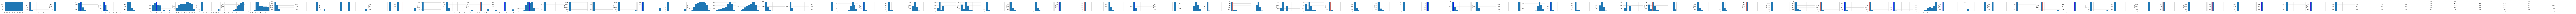

In [15]:
fn.grafestad_numbers(df, 50)

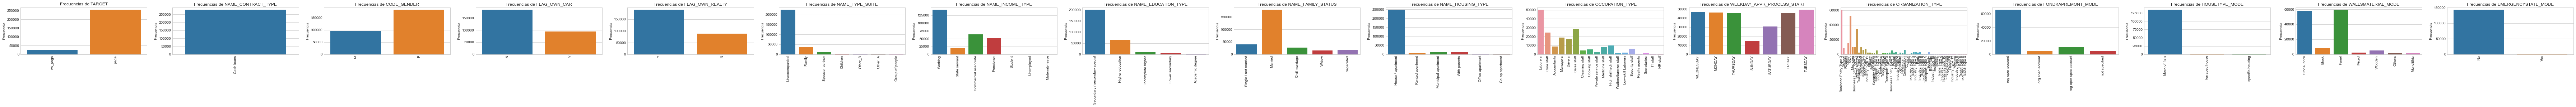

In [16]:
fn.grafestad_object(df, 10)

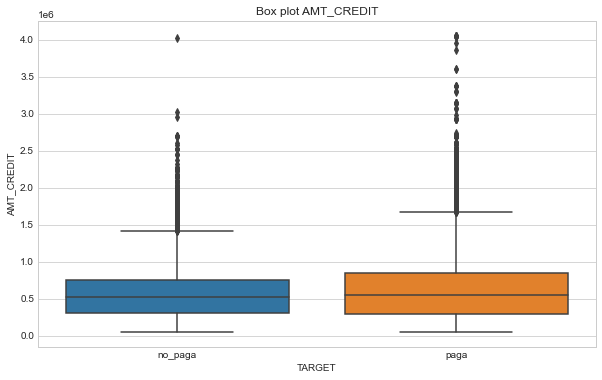

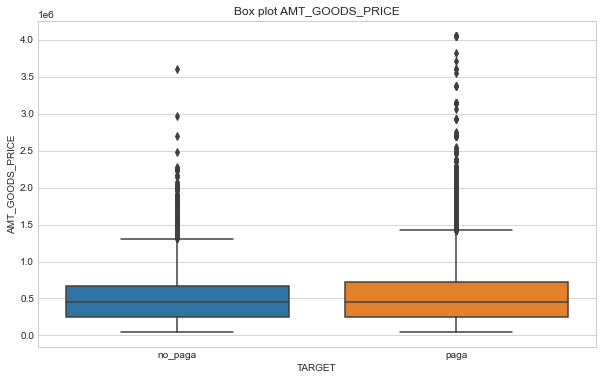

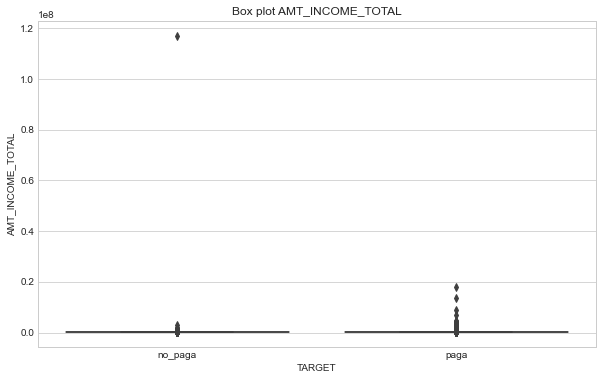

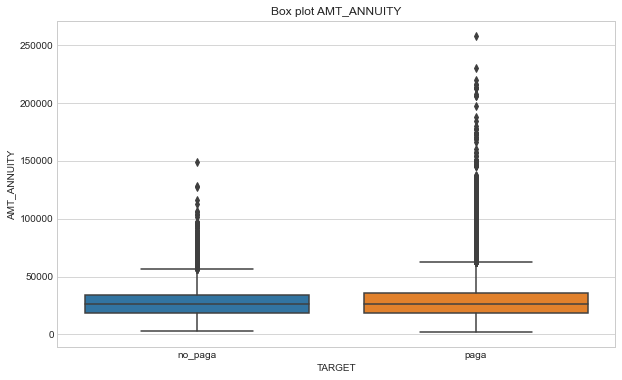

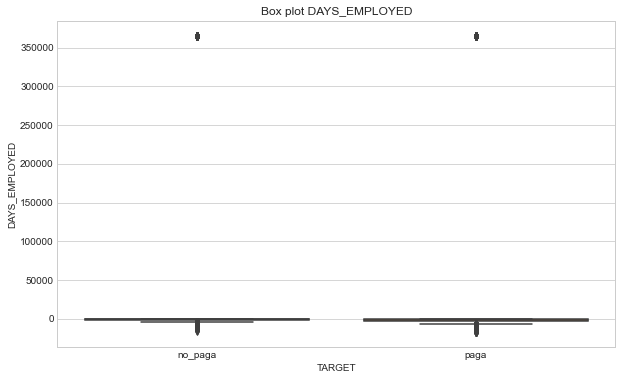

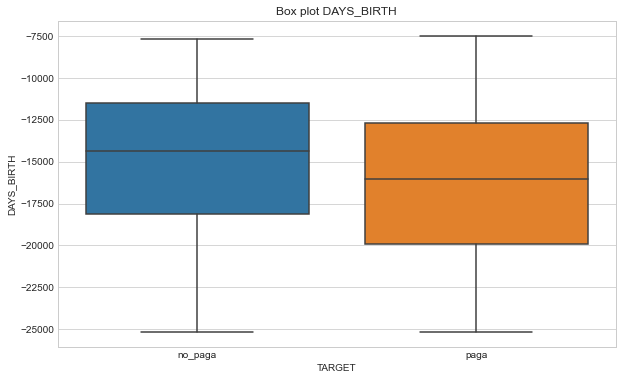

In [17]:
y_name = ["AMT_CREDIT", "AMT_GOODS_PRICE", "AMT_INCOME_TOTAL", "AMT_ANNUITY", "DAYS_EMPLOYED", 
          "DAYS_BIRTH"]
for i in y_name:
    fn.box_plot(df, i)

None
None
None


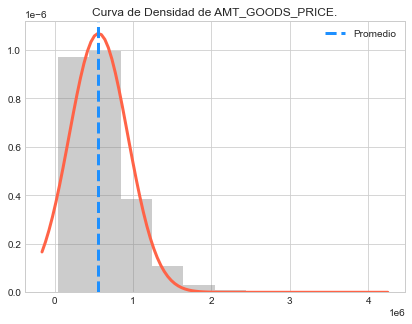

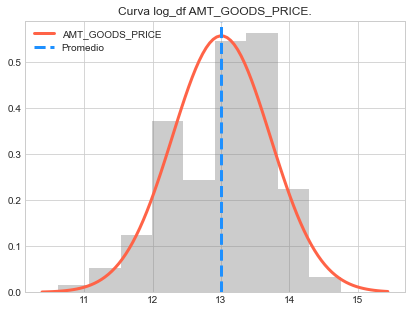

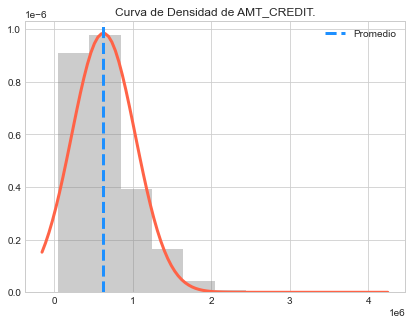

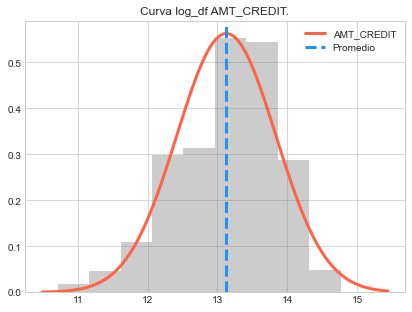

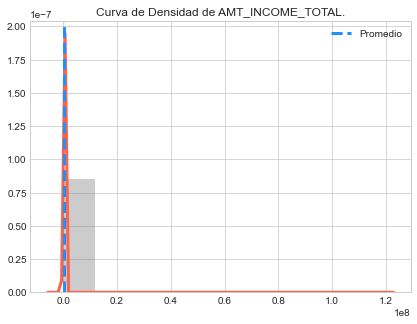

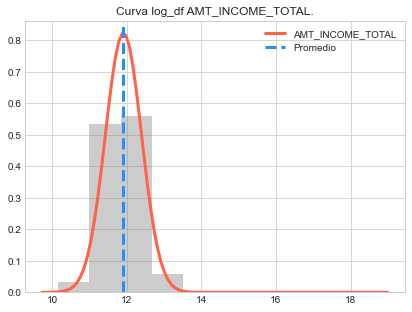

In [18]:
densidad_name = ['AMT_GOODS_PRICE', 'AMT_CREDIT', 'AMT_INCOME_TOTAL']
for i in densidad_name:
    fn.densidad(df, i)
    print(fn.densidad(df, i, log = True));

In [19]:
df.drop(["SK_ID_CURR","NAME_CONTRACT_TYPE","NAME_TYPE_SUITE","DAYS_REGISTRATION","DAYS_ID_PUBLISH","OWN_CAR_AGE",
         "WEEKDAY_APPR_PROCESS_START","HOUR_APPR_PROCESS_START","EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3",
         "APARTMENTS_AVG","BASEMENTAREA_AVG","YEARS_BEGINEXPLUATATION_AVG","YEARS_BUILD_AVG","COMMONAREA_AVG","ELEVATORS_AVG",
         "ENTRANCES_AVG","FLOORSMAX_AVG","FLOORSMIN_AVG","LANDAREA_AVG","LIVINGAPARTMENTS_AVG","LIVINGAREA_AVG",
         "NONLIVINGAPARTMENTS_AVG","NONLIVINGAREA_AVG","APARTMENTS_MODE","BASEMENTAREA_MODE","YEARS_BEGINEXPLUATATION_MODE",
         "YEARS_BUILD_MODE","COMMONAREA_MODE","ELEVATORS_MODE","ENTRANCES_MODE","FLOORSMAX_MODE","FLOORSMIN_MODE","LANDAREA_MODE",
         "LIVINGAPARTMENTS_MODE","LIVINGAREA_MODE","NONLIVINGAPARTMENTS_MODE","NONLIVINGAREA_MODE","APARTMENTS_MEDI","BASEMENTAREA_MEDI",
         "YEARS_BEGINEXPLUATATION_MEDI","YEARS_BUILD_MEDI","COMMONAREA_MEDI","ELEVATORS_MEDI","ENTRANCES_MEDI","FLOORSMAX_MEDI",
         "FLOORSMIN_MEDI","LANDAREA_MEDI","LIVINGAPARTMENTS_MEDI","LIVINGAREA_MEDI","NONLIVINGAPARTMENTS_MEDI","NONLIVINGAREA_MEDI",
         "FONDKAPREMONT_MODE","HOUSETYPE_MODE","TOTALAREA_MODE","WALLSMATERIAL_MODE","EMERGENCYSTATE_MODE","AMT_REQ_CREDIT_BUREAU_HOUR",
         "AMT_REQ_CREDIT_BUREAU_DAY","AMT_REQ_CREDIT_BUREAU_WEEK", "FLAG_DOCUMENT_2", "FLAG_DOCUMENT_3",
       "FLAG_DOCUMENT_4", "FLAG_DOCUMENT_5", "FLAG_DOCUMENT_6",
       "FLAG_DOCUMENT_7", "FLAG_DOCUMENT_8", "FLAG_DOCUMENT_9",
       "FLAG_DOCUMENT_10", "FLAG_DOCUMENT_11", "FLAG_DOCUMENT_12",
       "FLAG_DOCUMENT_13", "FLAG_DOCUMENT_14", "FLAG_DOCUMENT_15",
       "FLAG_DOCUMENT_16", "FLAG_DOCUMENT_17", "FLAG_DOCUMENT_18",
       "FLAG_DOCUMENT_19", "FLAG_DOCUMENT_20", "FLAG_DOCUMENT_21", "DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_LAST_PHONE_CHANGE", "FLAG_MOBIL", 
         "FLAG_CONT_MOBILE"], axis=1, inplace = True)

In [20]:
df["OCCUPATION_TYPE"].replace(np.nan,"UNKNOWN", inplace = True)

In [21]:
df.dropna(inplace = True)

In [22]:
df.replace(["Y", "N"], [1, 0], inplace = True)
df.replace(["M", "F"], [1, 0], inplace = True)

se normalizaron 3 atributos mediante la funcion logaritmo

In [23]:
df["AMT_CREDIT"]=np.log(df["AMT_CREDIT"])
df["AMT_GOODS_PRICE"]=np.log(df["AMT_GOODS_PRICE"])
df["AMT_INCOME_TOTAL"]=np.log(df["AMT_INCOME_TOTAL"])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240981 entries, 0 to 307510
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   TARGET                       240981 non-null  object 
 1   CODE_GENDER                  240981 non-null  int64  
 2   FLAG_OWN_CAR                 240981 non-null  int64  
 3   FLAG_OWN_REALTY              240981 non-null  int64  
 4   CNT_CHILDREN                 240981 non-null  int64  
 5   AMT_INCOME_TOTAL             240981 non-null  float64
 6   AMT_CREDIT                   240981 non-null  float64
 7   AMT_ANNUITY                  240981 non-null  float64
 8   AMT_GOODS_PRICE              240981 non-null  float64
 9   NAME_INCOME_TYPE             240981 non-null  object 
 10  NAME_EDUCATION_TYPE          240981 non-null  object 
 11  NAME_FAMILY_STATUS           240981 non-null  object 
 12  NAME_HOUSING_TYPE            240981 non-null  object 
 13 

### Analisis de correlaciones

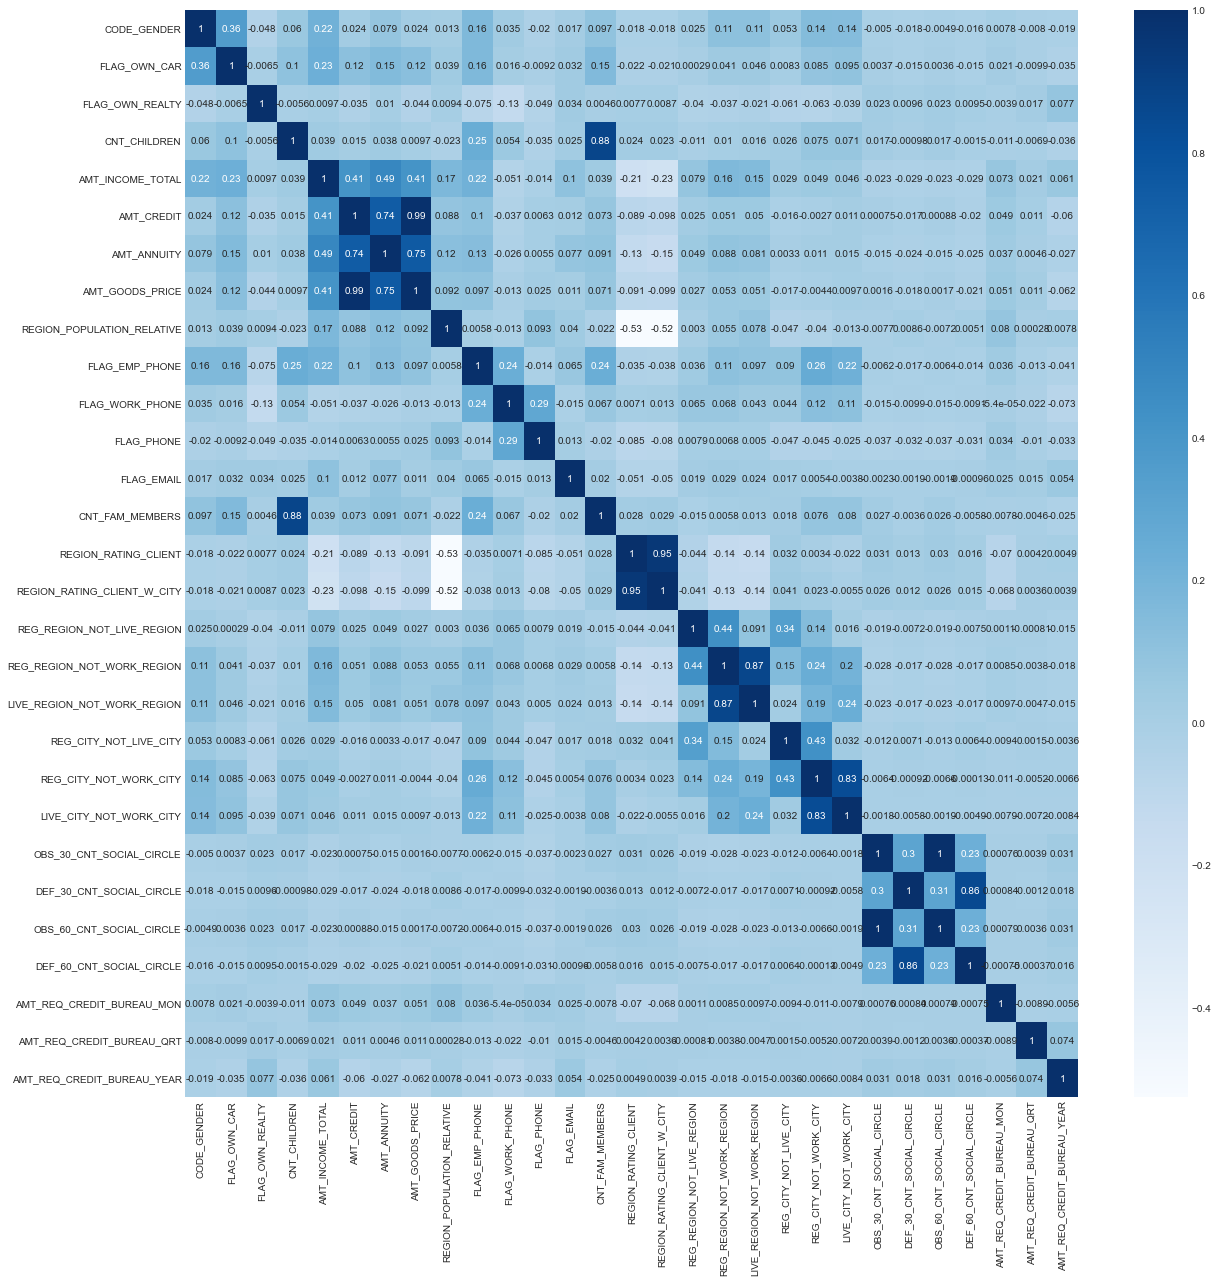

In [25]:
data=df.dropna()
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(),annot=True, cmap='Blues');

Se eliminan los atributos con correlacion entre ellas superior a 60% como prueba para la regresion logistica 

In [26]:
df_logit = data.drop(columns = ["AMT_GOODS_PRICE", "AMT_ANNUITY", "CNT_CHILDREN", 
                               "REGION_RATING_CLIENT_W_CITY", "LIVE_CITY_NOT_WORK_CITY", 
                                "DEF_60_CNT_SOCIAL_CIRCLE", "LIVE_REGION_NOT_WORK_REGION", 
                                "OBS_60_CNT_SOCIAL_CIRCLE"])

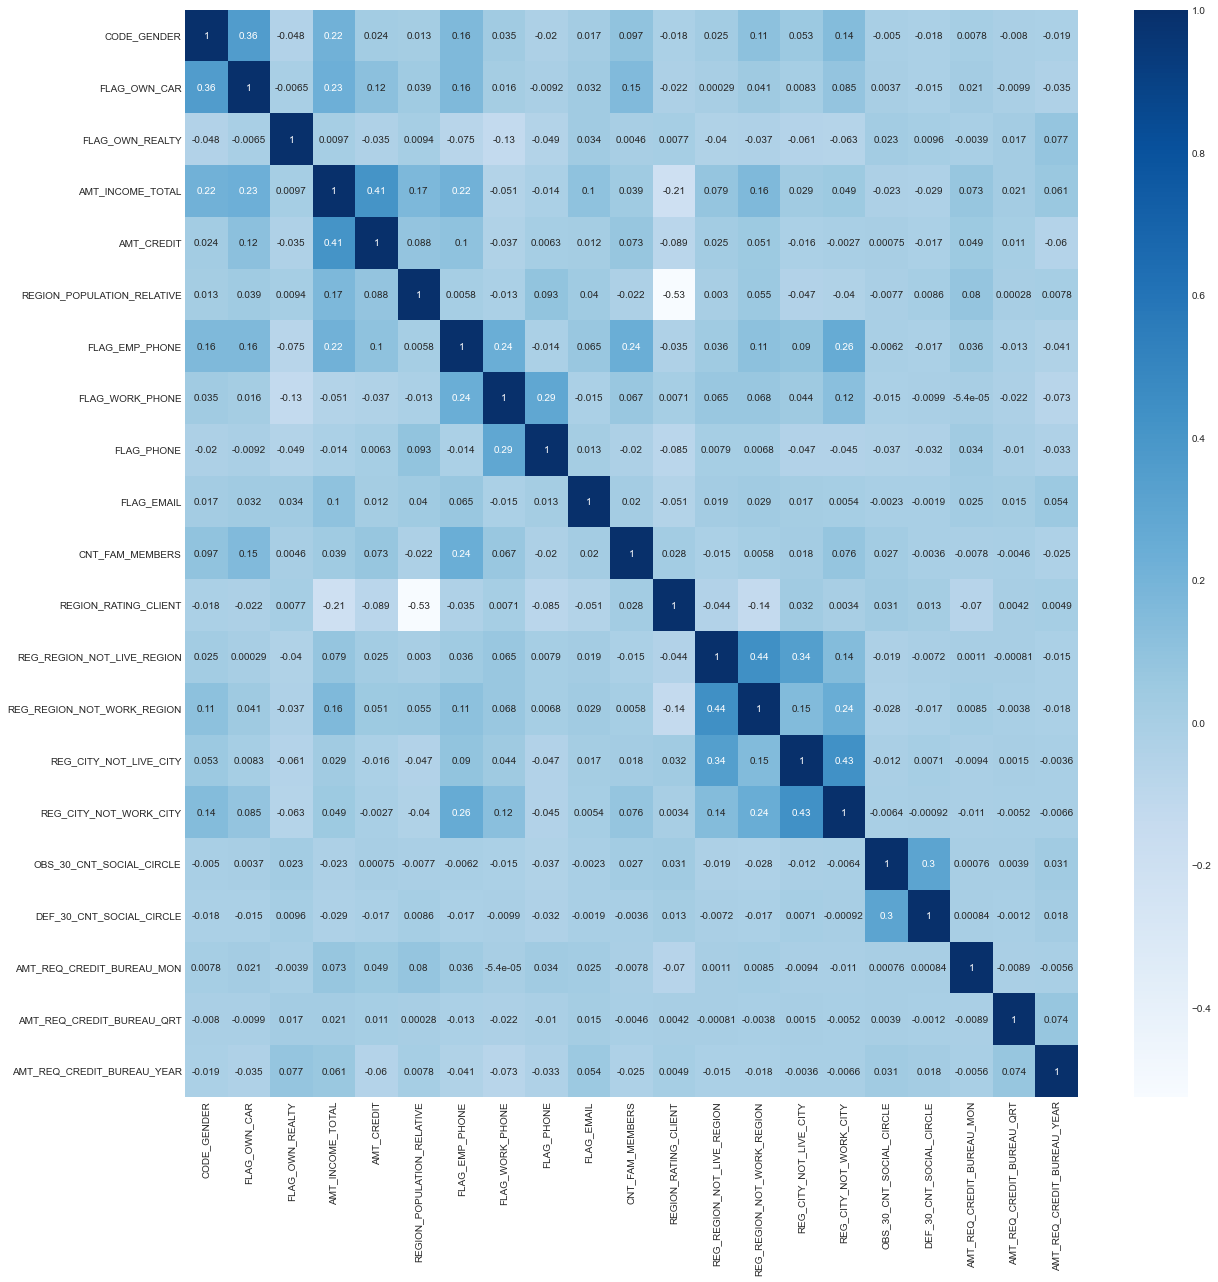

In [27]:
plt.figure(figsize=(20,20))
sns.heatmap(df_logit.corr(),annot=True, cmap='Blues');

In [28]:
df.shape

(240981, 36)

In [29]:
df.columns

Index(['TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

## Modelo descriptivo

In [30]:
df_desc = df.copy()
for column_name in df_desc.columns:
    if df_desc[column_name].dtype == 'object':
        df_desc[column_name] = LabelEncoder().fit_transform(df_desc[column_name])

In [31]:
df_desc

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,1,0,1,0,12.218495,12.915579,24700.5,12.768542,4,4,3,1,0.018801,1,0,1,0,8,1.0,2,2,0,0,0,0,0,0,5,2.0,2.0,2.0,2.0,0.0,0.0,1.0
1,1,0,0,0,0,12.506177,14.072864,35698.5,13.937286,2,1,1,1,0.003541,1,0,1,0,3,2.0,1,1,0,0,0,0,0,0,39,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,1,0,1,0,11.707670,13.148031,21865.5,13.148031,4,4,3,1,0.028663,1,0,0,0,3,1.0,2,2,0,0,0,0,1,1,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,1,0,1,0,11.502875,13.103171,27517.5,13.026953,2,4,1,1,0.035792,1,1,1,0,8,2.0,2,2,0,0,0,0,0,0,33,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6,1,0,1,1,1,12.049419,14.260662,41301.0,14.148405,0,1,1,1,0.035792,1,0,1,0,0,3.0,2,2,0,0,0,0,0,0,5,1.0,0.0,1.0,0.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307503,1,0,0,1,0,11.630709,12.752777,17770.5,12.419166,0,1,3,1,0.022800,1,0,0,1,3,1.0,2,2,0,0,0,0,0,0,2,9.0,3.0,9.0,2.0,1.0,0.0,2.0
307505,1,0,0,1,0,11.630709,12.323856,22050.0,12.323856,1,4,3,1,0.022800,0,0,1,0,17,1.0,2,2,0,0,0,0,0,0,57,0.0,0.0,0.0,0.0,2.0,0.0,0.0
307508,1,0,0,1,0,11.938193,13.426407,29979.0,13.279367,4,1,2,1,0.005002,1,0,0,1,10,1.0,3,3,0,0,0,0,1,1,39,6.0,0.0,6.0,0.0,1.0,0.0,1.0
307509,0,0,0,1,0,12.049419,12.821547,20205.0,12.674513,0,4,1,1,0.005313,1,0,0,0,8,2.0,2,2,0,0,0,1,1,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
#Modelo completo
parametros = 'TARGET ~ ' + " + ".join(df_desc.drop(["TARGET"], axis=1))
print (parametros)
mdesc_log1 = smf.logit(parametros , df_desc).fit(solver='newton')

mdesc_log1.summary().tables[0]

TARGET ~ CODE_GENDER + FLAG_OWN_CAR + FLAG_OWN_REALTY + CNT_CHILDREN + AMT_INCOME_TOTAL + AMT_CREDIT + AMT_ANNUITY + AMT_GOODS_PRICE + NAME_INCOME_TYPE + NAME_EDUCATION_TYPE + NAME_FAMILY_STATUS + NAME_HOUSING_TYPE + REGION_POPULATION_RELATIVE + FLAG_EMP_PHONE + FLAG_WORK_PHONE + FLAG_PHONE + FLAG_EMAIL + OCCUPATION_TYPE + CNT_FAM_MEMBERS + REGION_RATING_CLIENT + REGION_RATING_CLIENT_W_CITY + REG_REGION_NOT_LIVE_REGION + REG_REGION_NOT_WORK_REGION + LIVE_REGION_NOT_WORK_REGION + REG_CITY_NOT_LIVE_CITY + REG_CITY_NOT_WORK_CITY + LIVE_CITY_NOT_WORK_CITY + ORGANIZATION_TYPE + OBS_30_CNT_SOCIAL_CIRCLE + DEF_30_CNT_SOCIAL_CIRCLE + OBS_60_CNT_SOCIAL_CIRCLE + DEF_60_CNT_SOCIAL_CIRCLE + AMT_REQ_CREDIT_BUREAU_MON + AMT_REQ_CREDIT_BUREAU_QRT + AMT_REQ_CREDIT_BUREAU_YEAR
Optimization terminated successfully.
         Current function value: 0.268277
         Iterations 7


Dep. Variable:,TARGET,No. Observations:,240981
Model:,Logit,Df Residuals:,240945
Method:,MLE,Df Model:,35
Date:,"Wed, 14 Sep 2022",Pseudo R-squ.:,0.03615
Time:,21:12:00,Log-Likelihood:,-64650.
converged:,True,LL-Null:,-67074.
Covariance Type:,nonrobust,LLR p-value:,0.000


In [33]:
mdesc_log1.summary2().tables[1].sort_values(by="P>|z|", ascending=True)[0:40]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
AMT_CREDIT,-1.976908,7.370554e-02,-26.821704,1.804257e-158,-2.121369,-1.832448
AMT_GOODS_PRICE,2.009127,7.491941e-02,26.817180,2.037377e-158,1.862288,2.155967
CODE_GENDER,-0.446514,1.724159e-02,-25.897485,7.108648e-148,-0.480307,-0.412721
NAME_EDUCATION_TYPE,-0.127582,6.755890e-03,-18.884487,1.530168e-79,-0.140823,-0.114340
FLAG_OWN_CAR,0.313861,1.792675e-02,17.507960,1.245782e-68,0.278725,0.348997
FLAG_WORK_PHONE,-0.244689,2.019562e-02,-12.115923,8.697907e-34,-0.284271,-0.205106
CNT_CHILDREN,-0.443370,4.147751e-02,-10.689416,1.140875e-26,-0.524665,-0.362076
Intercept,3.366168,3.201796e-01,10.513374,7.496281e-26,2.738627,3.993708
CNT_FAM_MEMBERS,0.391119,3.921459e-02,9.973808,1.984701e-23,0.314260,0.467978
FLAG_EMP_PHONE,-0.328721,3.324236e-02,-9.888608,4.664681e-23,-0.393874,-0.263567


In [34]:
df_recoded = df.copy()

for column, item in df_recoded.drop(['TARGET'], axis=1).iteritems():
    if (item.dtype == "object") & (item.value_counts().size > 1):
        #Limpia datos antes de transformar en columnas 
        df_recoded[column] = df_recoded[column].str.replace("[/| |:|-]", "_").str.upper()
        print(f'...Binarizando variables con mas de una categoria\n   Columna: {column}  \t Tipo: {item.dtype} \t values: \n{item.value_counts().sort_values(ascending=True)}', sep="\n")
        df_dummy = pd.get_dummies(df_recoded[column], drop_first=True, prefix = column )
        df_recoded = pd.concat([df_recoded, df_dummy], axis = 1)
        #Elimino columna ya que se binarizó
        df_recoded.drop([column], axis=1, inplace=True)

...Binarizando variables con mas de una categoria
   Columna: NAME_INCOME_TYPE  	 Tipo: object 	 values: 
Student                     12
State servant            17847
Pensioner                44791
Commercial associate     55165
Working                 123166
Name: NAME_INCOME_TYPE, dtype: int64
...Binarizando variables con mas de una categoria
   Columna: NAME_EDUCATION_TYPE  	 Tipo: object 	 values: 
Academic degree                     128
Lower secondary                    2976
Incomplete higher                  7606
Higher education                  58278
Secondary / secondary special    171993
Name: NAME_EDUCATION_TYPE, dtype: int64
...Binarizando variables con mas de una categoria
   Columna: NAME_FAMILY_STATUS  	 Tipo: object 	 values: 
Widow                    12927
Separated                15636
Civil marriage           22653
Single / not married     32949
Married                 156816
Name: NAME_FAMILY_STATUS, dtype: int64
...Binarizando variables con mas de una categoria
 

In [35]:
pd.set_option('display.max_columns', 150)
df_recoded.head()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_INCOME_TYPE_PENSIONER,NAME_INCOME_TYPE_STATE_SERVANT,NAME_INCOME_TYPE_STUDENT,NAME_INCOME_TYPE_WORKING,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,NAME_EDUCATION_TYPE_INCOMPLETE_HIGHER,NAME_EDUCATION_TYPE_LOWER_SECONDARY,NAME_EDUCATION_TYPE_SECONDARY___SECONDARY_SPECIAL,NAME_FAMILY_STATUS_MARRIED,NAME_FAMILY_STATUS_SEPARATED,NAME_FAMILY_STATUS_SINGLE___NOT_MARRIED,NAME_FAMILY_STATUS_WIDOW,NAME_HOUSING_TYPE_HOUSE___APARTMENT,NAME_HOUSING_TYPE_MUNICIPAL_APARTMENT,NAME_HOUSING_TYPE_OFFICE_APARTMENT,NAME_HOUSING_TYPE_RENTED_APARTMENT,NAME_HOUSING_TYPE_WITH_PARENTS,OCCUPATION_TYPE_CLEANING_STAFF,OCCUPATION_TYPE_COOKING_STAFF,OCCUPATION_TYPE_CORE_STAFF,OCCUPATION_TYPE_DRIVERS,OCCUPATION_TYPE_HIGH_SKILL_TECH_STAFF,OCCUPATION_TYPE_HR_STAFF,OCCUPATION_TYPE_IT_STAFF,OCCUPATION_TYPE_LABORERS,OCCUPATION_TYPE_LOW_SKILL_LABORERS,OCCUPATION_TYPE_MANAGERS,OCCUPATION_TYPE_MEDICINE_STAFF,OCCUPATION_TYPE_PRIVATE_SERVICE_STAFF,OCCUPATION_TYPE_REALTY_AGENTS,OCCUPATION_TYPE_SALES_STAFF,OCCUPATION_TYPE_SECRETARIES,OCCUPATION_TYPE_SECURITY_STAFF,OCCUPATION_TYPE_UNKNOWN,OCCUPATION_TYPE_WAITERS_BARMEN_STAFF,ORGANIZATION_TYPE_AGRICULTURE,ORGANIZATION_TYPE_BANK,ORGANIZATION_TYPE_BUSINESS_ENTITY_TYPE_1,ORGANIZATION_TYPE_BUSINESS_ENTITY_TYPE_2,ORGANIZATION_TYPE_BUSINESS_ENTITY_TYPE_3,ORGANIZATION_TYPE_CLEANING,ORGANIZATION_TYPE_CONSTRUCTION,ORGANIZATION_TYPE_CULTURE,ORGANIZATION_TYPE_ELECTRICITY,ORGANIZATION_TYPE_EMERGENCY,ORGANIZATION_TYPE_GOVERNMENT,ORGANIZATION_TYPE_HOTEL,ORGANIZATION_TYPE_HOUSING,ORGANIZATION_TYPE_INDUSTRY__TYPE_1,ORGANIZATION_TYPE_INDUSTRY__TYPE_10,ORGANIZATION_TYPE_INDUSTRY__TYPE_11,ORGANIZATION_TYPE_INDUSTRY__TYPE_12,ORGANIZATION_TYPE_INDUSTRY__TYPE_13,ORGANIZATION_TYPE_INDUSTRY__TYPE_2,ORGANIZATION_TYPE_INDUSTRY__TYPE_3,ORGANIZATION_TYPE_INDUSTRY__TYPE_4,ORGANIZATION_TYPE_INDUSTRY__TYPE_5,ORGANIZATION_TYPE_INDUSTRY__TYPE_6,ORGANIZATION_TYPE_INDUSTRY__TYPE_7,ORGANIZATION_TYPE_INDUSTRY__TYPE_8,ORGANIZATION_TYPE_INDUSTRY__TYPE_9,ORGANIZATION_TYPE_INSURANCE,ORGANIZATION_TYPE_KINDERGARTEN,ORGANIZATION_TYPE_LEGAL_SERVICES,ORGANIZATION_TYPE_MEDICINE,ORGANIZATION_TYPE_MILITARY,ORGANIZATION_TYPE_MOBILE,ORGANIZATION_TYPE_OTHER,ORGANIZATION_TYPE_POLICE,ORGANIZATION_TYPE_POSTAL,ORGANIZATION_TYPE_REALTOR,ORGANIZATION_TYPE_RELIGION,ORGANIZATION_TYPE_RESTAURANT,ORGANIZATION_TYPE_SCHOOL,ORGANIZATION_TYPE_SECURITY,ORGANIZATION_TYPE_SECURITY_MINISTRIES,ORGANIZATION_TYPE_SELF_EMPLOYED,ORGANIZATION_TYPE_SERVICES,ORGANIZATION_TYPE_TELECOM,ORGANIZATION_TYPE_TRADE__TYPE_1,ORGANIZATION_TYPE_TRADE__TYPE_2,ORGANIZATION_TYPE_TRADE__TYPE_3,ORGANIZATION_TYPE_TRADE__TYPE_4,ORGANIZATION_TYPE_TRADE__TYPE_5,ORGANIZATION_TYPE_TRADE__TYPE_6,ORGANIZATION_TYPE_TRADE__TYPE_7,ORGANIZATION_TYPE_TRANSPORT__TYPE_1,ORGANIZATION_TYPE_TRANSPORT__TYPE_2,ORGANIZATION_TYPE_TRANSPORT__TYPE_3,ORGANIZATION_TYPE_TRANSPORT__TYPE_4,ORGANIZATION_TYPE_UNIVERSITY,ORGANIZATION_TYPE_XNA
0,no_paga,1,0,1,0,12.218495,12.915579,24700.5,12.768542,0.018801,1,0,1,0,1.0,2,2,0,0,0,0,0,0,2.0,2.0,2.0,2.0,0.0,0.0,1.0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,paga,0,0,0,0,12.506177,14.072864,35698.5,13.937286,0.003541,1,0,1,0,2.0,1,1,0,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## Entrenamiento de modelos

primeramente se hace un entrenamiento de modelos sin incluir los hiperparametros, de esta forma se genera una idea de como se comporta el dataset en el entrenamiento.

In [36]:
X = df_recoded.drop(columns='TARGET')
y = df_recoded['TARGET']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=20639)

## Regresion Logistica	

In [38]:
lr =LogisticRegression().fit(X_train, y_train)

In [39]:
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

     no_paga       0.00      0.00      0.00      5764
        paga       0.92      1.00      0.96     66531

    accuracy                           0.92     72295
   macro avg       0.46      0.50      0.48     72295
weighted avg       0.85      0.92      0.88     72295



## Naive Bayes

In [40]:
bnb = BernoulliNB().fit(X_train, y_train)

In [41]:
print(classification_report(y_test, bnb.predict(X_test)))

              precision    recall  f1-score   support

     no_paga       0.16      0.03      0.04      5764
        paga       0.92      0.99      0.95     66531

    accuracy                           0.91     72295
   macro avg       0.54      0.51      0.50     72295
weighted avg       0.86      0.91      0.88     72295



## Random Forest

In [42]:
rfc = RandomForestClassifier().fit(X_train, y_train)

In [43]:
print(classification_report(y_test, rfc.predict(X_test)))

              precision    recall  f1-score   support

     no_paga       1.00      0.00      0.00      5764
        paga       0.92      1.00      0.96     66531

    accuracy                           0.92     72295
   macro avg       0.96      0.50      0.48     72295
weighted avg       0.93      0.92      0.88     72295



## Adaptative Boosting

In [44]:
ab = AdaBoostClassifier().fit(X_train, y_train)

In [45]:
print(classification_report(y_test, ab.predict(X_test)))

              precision    recall  f1-score   support

     no_paga       0.00      0.00      0.00      5764
        paga       0.92      1.00      0.96     66531

    accuracy                           0.92     72295
   macro avg       0.46      0.50      0.48     72295
weighted avg       0.85      0.92      0.88     72295



## Gradient Boosting

In [46]:
gb = GradientBoostingClassifier(random_state=20639431).fit(X_train, y_train)

In [47]:
print(classification_report(y_test, gb.predict(X_test)))

              precision    recall  f1-score   support

     no_paga       0.00      0.00      0.00      5764
        paga       0.92      1.00      0.96     66531

    accuracy                           0.92     72295
   macro avg       0.46      0.50      0.48     72295
weighted avg       0.85      0.92      0.88     72295



## SVM

In [48]:
svm = SVC(kernel='rbf').fit(X_train, y_train)

In [49]:
print(classification_report(y_test, svm.predict(X_test)))

              precision    recall  f1-score   support

     no_paga       0.00      0.00      0.00      5764
        paga       0.92      1.00      0.96     66531

    accuracy                           0.92     72295
   macro avg       0.46      0.50      0.48     72295
weighted avg       0.85      0.92      0.88     72295



# Balanceo de la muestra

Dado que el resultado del primer entrenamiento resulto en todos los modelos en una mala prediccion de la variable target igual 1, que representa el

In [50]:
df_recoded['TARGET'] = np.where(df_recoded['TARGET'] == 'no_paga', 1, 0)

In [51]:
df_balanced = df_recoded[df_recoded["TARGET"]== 0 ].sample(frac=0.33)
df_balanced = pd.concat([df_balanced, df_recoded[df_recoded["TARGET"]==1]])

In [52]:
df_balanced.shape

(92412, 122)

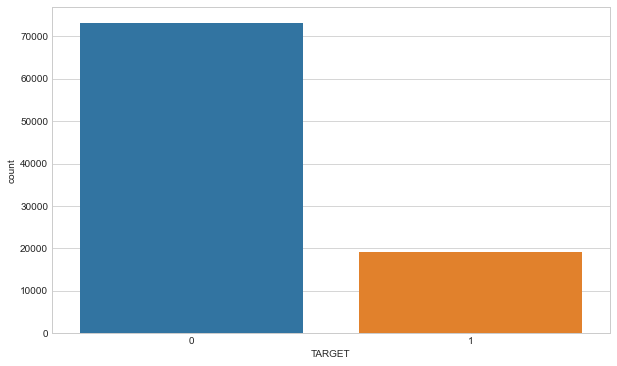

In [53]:
sns.countplot(x = df_balanced['TARGET'], order = df_balanced['TARGET'].value_counts().index);

In [54]:
X_b = df_balanced.drop(columns='TARGET')
y_b = df_balanced['TARGET']

In [55]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=.3, random_state=20639)

## Regresion Logistica balanceado

In [56]:
param_grid_logistic_regression = { 'C':[0.0001, 0.001, 0.01, 0.1], 'penalty':['none','l2'], 
                                  'class_weight': ['balanced'],'solver':['newton-cg']}

In [57]:
lr_b =LogisticRegression()

In [58]:
grid_lr_b = GridSearchCV(lr_b, param_grid= param_grid_logistic_regression, 
                                        cv=2).fit(X_train_b, y_train_b)

In [59]:
grid_lr_b.best_params_

{'C': 0.0001,
 'class_weight': 'balanced',
 'penalty': 'none',
 'solver': 'newton-cg'}

In [60]:
print(classification_report(y_test_b, grid_lr_b.predict(X_test_b)))

              precision    recall  f1-score   support

           0       0.85      0.61      0.71     21976
           1       0.29      0.60      0.39      5748

    accuracy                           0.61     27724
   macro avg       0.57      0.61      0.55     27724
weighted avg       0.74      0.61      0.65     27724



In [61]:
# modelo Regresion Logistica serializado 
pickle.dump(grid_lr_b, open("grid_lr_b.pkl", "wb"))
# read_model = pickle.load(open('grid_lr_b.pkl', 'rb'))

## Naive Bayes balanceado

In [62]:
bnb_params = {'alpha': [0.1, 0.5, 1], 'fit_prior':[True,False]}

In [63]:
bnb_b = BernoulliNB()

In [64]:
grid_bnb_b = GridSearchCV(bnb_b, bnb_params, cv=5, n_jobs=-1).fit(X_train_b, y_train_b)

In [65]:
grid_bnb_b.best_params_

{'alpha': 1, 'fit_prior': True}

In [66]:
print(classification_report(y_test_b, grid_bnb_b.predict(X_test_b)))

              precision    recall  f1-score   support

           0       0.81      0.88      0.85     21976
           1       0.34      0.23      0.27      5748

    accuracy                           0.75     27724
   macro avg       0.58      0.56      0.56     27724
weighted avg       0.72      0.75      0.73     27724



In [67]:
# modelo Naive Bayes serializado 
pickle.dump(grid_bnb_b, open("grid_bnb_b.pkl", "wb"))
# read_model = pickle.load(open('grid_bnb_b.pkl', 'rb'))

## Random Forest balanceado

In [68]:
rf_params = {'n_estimators': [50, 200, 500], 'max_features': [.5, .7, 'log2'],'bootstrap':[False, True],
             'max_depth':[3,6,8], 'class_weight': ['balanced'], 'criterion':['entropy']}

In [69]:
rfc_b = RandomForestClassifier()

In [70]:
grid_rfc_b = GridSearchCV(rfc_b, rf_params, cv=2, n_jobs=-1).fit(X_train_b, y_train_b)

In [71]:
grid_rfc_b.best_params_

{'bootstrap': True,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 0.7,
 'n_estimators': 200}

In [72]:
print(classification_report(y_test_b, grid_rfc_b.predict(X_test_b)))

              precision    recall  f1-score   support

           0       0.86      0.64      0.74     21976
           1       0.30      0.58      0.40      5748

    accuracy                           0.63     27724
   macro avg       0.58      0.61      0.57     27724
weighted avg       0.74      0.63      0.66     27724



In [73]:
# modelo Random Forest serializado 
pickle.dump(grid_rfc_b, open("grid_rfc_b.pkl", "wb"))
# read_model = pickle.load(open('grid_rfc_b.pkl', 'rb'))

## Adaptative Boosting balanceado

In [74]:
#ab_params = {'n_estimators': [100, 1000, 10], 'learning_rate': [0.01, 100, 10]}

In [75]:
#ab_b = AdaBoostClassifier().fit(X_train_b, y_train_b)

In [76]:
#grid_ab = GridSearchCV(ab_b, ab_params, cv=2, n_jobs=-1).fit(X_train_b, y_train_b)

In [77]:
#grid_ab.best_params_

In [78]:
#print(classification_report(y_test_b, grid_ab.predict(X_test_b)))

## Gradient Boosting balanceado

In [79]:
#gb_params = {'n_estimators': [100, 500, 1000], 'learning_rate': [0.01, 0.1, 0.5, 1], 
 #           'subsample': np.linspace(0.01, 1.0, 5, endpoint=True, dtype=float), 
  #          'max_features': ['auto', 'sqrt', 'log2']}

In [80]:
#gb_b = GradientBoostingClassifier(random_state=20639431).fit(X_train_b, y_train_b)

In [81]:
#grid_gb_b = GridSearchCV(gb_b, gb_params, cv=2, n_jobs=-1).fit(X_train_b, y_train_b)

In [82]:
#grid_gb.best_params_

In [83]:
#print(classification_report(y_test_b, grid_gb_b.predict(X_test_b)))

## SVM balanceado

In [84]:
#svm_params = {'C': [0.1, 1, 5],'gamma': [0.0001, 0.01, 0.1]}

In [85]:
#svm_b = SVC(kernel='rbf').fit(X_train_b, y_train_b)

In [86]:
#grid_svm = GridSearchCV(svm_b, svm_params, cv=2, n_jobs=6).fit(X_train_b, y_train_b)

In [87]:
#grid_svm.best_params_

In [88]:
#print(classification_report(y_test_b, grid_svm.predict(X_test_b)))

In [89]:
probs_lr = grid_lr_b.predict_proba(X_test_b)
preds_lr = probs_lr[:,1]
fpr_lr, tpr_lr, threshold_lr = metrics.roc_curve(y_test_b, preds_lr)
roc_auc_lr = metrics.auc(fpr_lr, tpr_lr)

probs_NB = grid_bnb_b.predict_proba(X_test_b)
preds_NB = probs_NB[:,1]
fpr_NB, tpr_NB, threshold_NB = metrics.roc_curve(y_test_b, preds_NB)
roc_auc_NB = metrics.auc(fpr_NB, tpr_NB)

probs_rf = grid_rfc_b.predict_proba(X_test_b)
preds_rf = probs_rf[:,1]
fpr_rf, tpr_rf, threshold_rf = metrics.roc_curve(y_test_b, preds_rf)
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)

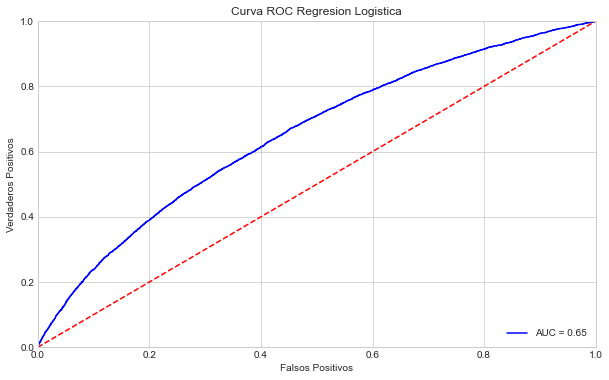

In [90]:
plt.title('Curva ROC Regresion Logistica')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos')
plt.show()

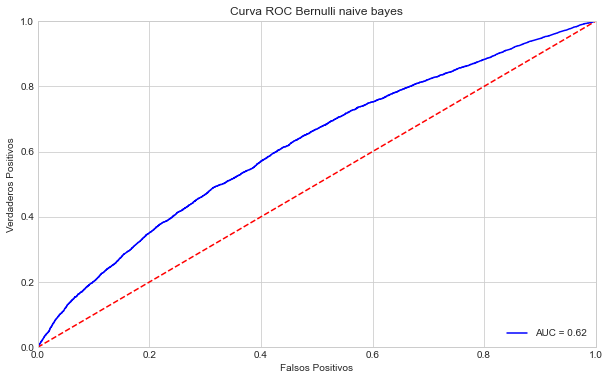

In [91]:
plt.title('Curva ROC Bernulli naive bayes')
plt.plot(fpr_NB, tpr_NB, 'b', label = 'AUC = %0.2f' % roc_auc_NB)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos')
plt.show()

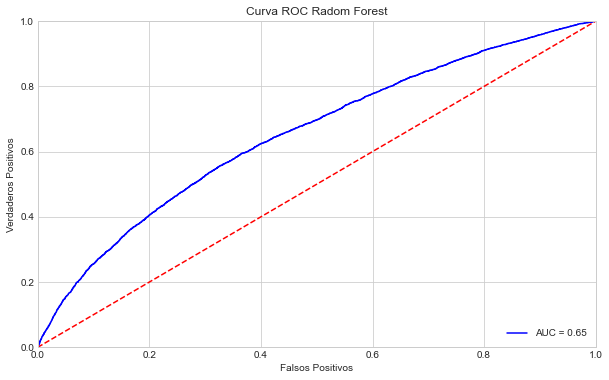

In [92]:
plt.title('Curva ROC Radom Forest')
plt.plot(fpr_rf, tpr_rf, 'b', label = 'AUC = %0.2f' % roc_auc_rf)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos')
plt.show()

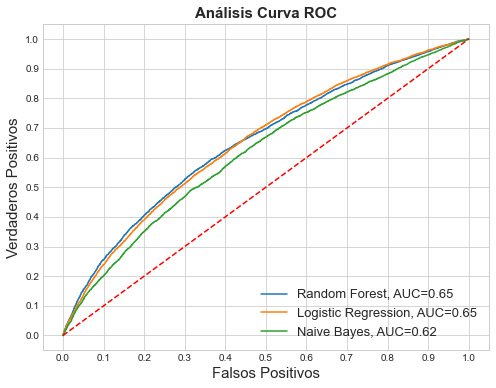

In [93]:
fpr = []
fpr.append(fpr_rf)
fpr.append(fpr_lr)
fpr.append(fpr_NB)


tpr = []
tpr.append(tpr_rf)
tpr.append(tpr_lr)
tpr.append(tpr_NB)


auc  = []
auc.append(roc_auc_rf)
auc.append(roc_auc_lr)
auc.append(roc_auc_NB)

cur_roc = pd.DataFrame()
cur_roc['modelo']=['Random Forest', 'Logistic Regression', 'Naive Bayes']
cur_roc['fpr']=fpr
cur_roc['tpr']=tpr
cur_roc['auc']=auc
cur_roc.set_index('modelo', inplace=True)
fig = plt.figure(figsize=(8,6))

for i in cur_roc.index:
    plt.plot(cur_roc.loc[i]['fpr'], 
             cur_roc.loc[i]['tpr'], 
             label="{}, AUC={:.2f}".format(i, cur_roc.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='red', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Falsos Positivos", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("Verdaderos Positivos", fontsize=15)

plt.title('Análisis Curva ROC', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()